In [0]:
!kill -9 -1

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp8gi58nlh/pubring.gpg' created
gpg: /tmp/tmp8gi58nlh/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# !google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [2]:
!ls

datalab  drive


In [0]:
import os
os.chdir("drive/Colab Notebooks/Deep Heart/")

In [4]:
!ls

1.jpg  CNN_Focus_Grad-CAM.ipynb


In [0]:
!pip install -q keras

In [0]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [7]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
model = VGG16(weights='imagenet')
img_path = './1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x) # Subtract VGG RGB Mean

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

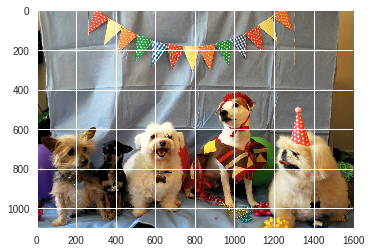

In [18]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.imshow(img[...,[2,1,0]])
# cv2.waitKey(0)
# cv2.closeAllWindows()
# cv2.waitKey(1)
# cv2.waitKey(1)
# cv2.waitKey(1)
# cv2.waitKey(1)

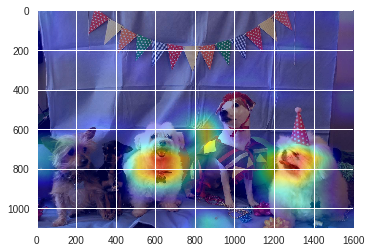

In [19]:
plt.imshow(superimposed_img[...,[2,1,0]])
# cv2.waitKey(0)
# cv2.closeAllWindows()
# cv2.waitKey(1)
# cv2.waitKey(1)
# cv2.waitKey(1)
# cv2.waitKey(1)

In [20]:
# grads = K.gradients(class_output, last_conv_layer.output)[0]
# pooled_grads = K.mean(grads, axis=(0, 1, 2))
# iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# pooled_grads_value, conv_layer_output_value = iterate([x])
grads.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(512)])

In [21]:
pooled_grads.shape

TensorShape([Dimension(512)])